# Imports

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.converters import circuit_to_dag

from graph_cutter import *

def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

second_order_formula = SuzukiTrotter()

L = 3
H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=np.pi / 8)
final_time = np.pi
num_timesteps = 10
dt = final_time / num_timesteps
initial_state = Statevector.from_label("000")

trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
for i in range(1):
    circuit.append(trotter_step_second_order, range(H.num_qubits))
# circuit = circuit.decompose(reps=1)
target_basis = ['rx', 'ry', 'rz', 'h', 'cx']
circuit = transpile(circuit,
                       basis_gates=target_basis, 
                       optimization_level=1) 

# Let us print some stats
# print(
#     f"""
# Trotter step with Suzuki Trotter (2nd order)
# --------------------------------------------

#                   Depth: {circuit.depth()}
#              Gate count: {len(circuit)}
#     Nonlocal gate count: {circuit.num_nonlocal_gates()}
#          Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

# """
# )
# print(H)

# circuit.draw("mpl", scale=0.5)

# Test

In [2]:
# c = QuantumCircuit(2)
# c.cx(0,1)
# c.h(1)
# c.cx(1,0)
# n_vertices, gate_edges, wire_edges, node_name_ids, id_node_names = read_circ(disconnect_cnot(c))
# G = nx.Graph() 
# all_edges = gate_edges+wire_edges
# G.add_edges_from(all_edges)
# label_dict = {}
# for i in list(node_name_ids.values()):
#     label_dict[i[0]] = i[1]

In [3]:
# c.draw()

In [4]:
# nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b', labels={node: label_dict[node] for node in G.nodes()}, with_labels=True)

# Sim

In [5]:
n_vertices, gate_edges, wire_edges, node_name_ids, id_node_names = read_circ(disconnect_cnot(circuit.copy()))
G = nx.Graph() 
all_edges = gate_edges+wire_edges
G.add_edges_from(all_edges)
label_dict = {}
for i in list(node_name_ids.values()):
    label_dict[i[0]] = i[1]

In [6]:
# print(G)
# nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b', labels={node: label_dict[node] for node in G.nodes()}, with_labels=True)

In [7]:
edge_cut_list, G_cut, partition, single_op = cutter(G, 8)
print(edge_cut_list, single_op)

[(0, 1), (1, 2), (2, 4), (3, 4), (6, 7), (12, 16), (16, 17)] {16, 1, 2}


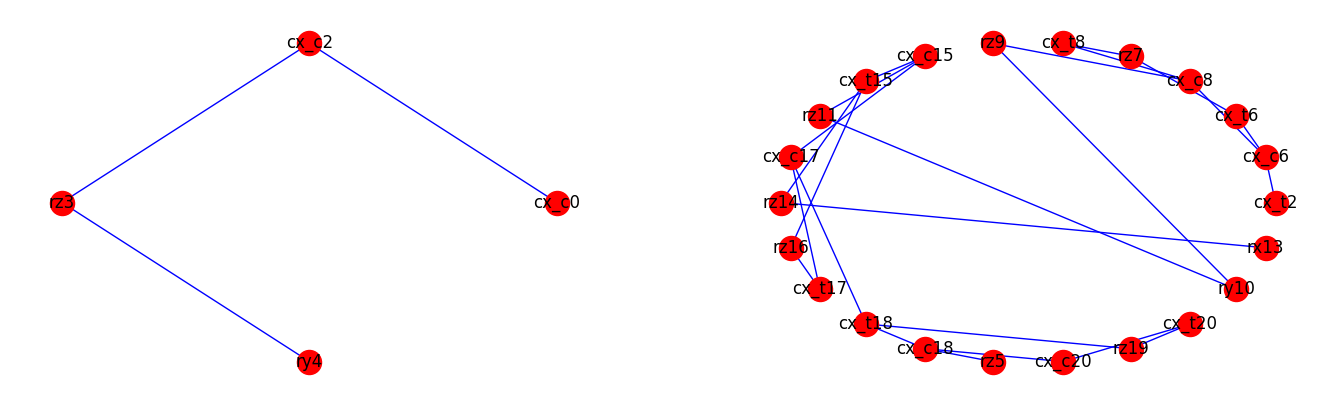

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=len(G_cut), figsize=(17,5))
ax = axes.flatten()

for i in range(len(G_cut)):
    nx.draw_networkx(G_cut[i], ax=ax[i], pos=nx.circular_layout(G_cut[i]), node_color='r', edge_color='b', labels={node: label_dict[node] for node in G_cut[i].nodes()}, with_labels=True)
    ax[i].set_axis_off()

plt.show()

In [16]:
if single_op is not None:
    single_circs = []
    for op_s in list(single_op):
        subcircuit = QuantumCircuit(1)
        op = node_name_ids[id_node_names[op_s]]
        sq = QuantumCircuit(1, name=op[1])
        sq_ins = sq.to_instruction()
        subcircuit.data.insert(0,(sq_ins,[Qubit(QuantumRegister(subcircuit.num_qubits, 'q'),0)],[])) 
        single_circs.append(subcircuit)

In [19]:
single_circs[2].draw()

┌─────┐
q: ┤ rz1 ├
   └─────┘

In [9]:
n = []
s = []
for i in range(len(G_cut)):
    n.append(list(G_cut[i].nodes()))
    s.append(cut_parser(node_name_ids, id_node_names, sorted(n[-1])))

In [10]:
print(n[0])
s[0].draw()

[0, 3, 5, 6]


┌───────┐┌───────┐┌─────┐┌─────┐
q: ┤ cx_c0 ├┤ cx_c2 ├┤ rz3 ├┤ ry4 ├
   └───────┘└───────┘└─────┘└─────┘

In [11]:
print(n[1])
s[1].draw()

[4, 8, 9, 11, 10, 12, 13, 19, 20, 15, 22, 18, 21, 23, 25, 24, 7, 27, 26, 28, 14, 17]


┌─────┐                                                               »
q_0: ─┤ rz5 ├───────────────────────────────────────────────────────────────»
     ┌┴─────┴┐┌────────┐       ┌────────┐┌─────┐ ┌──────┐┌──────┐┌─────────┐»
q_1: ┤ cx_t2 ├┤0       ├───────┤0       ├┤ rz9 ├─┤ ry10 ├┤ rz11 ├┤0        ├»
     └───────┘│  cnot6 │┌─────┐│  cnot8 │├─────┴┐├──────┤└──────┘│  cnot15 │»
q_2: ─────────┤1       ├┤ rz7 ├┤1       ├┤ rx13 ├┤ rz14 ├────────┤1        ├»
              └────────┘└─────┘└────────┘└──────┘└──────┘        └─────────┘»
«                        ┌─────────┐        ┌─────────┐
«q_0: ───────────────────┤0        ├────────┤0        ├
«             ┌─────────┐│  cnot18 │┌──────┐│  cnot20 │
«q_1: ────────┤0        ├┤1        ├┤ rz19 ├┤1        ├
«     ┌──────┐│  cnot17 │└─────────┘└──────┘└─────────┘
«q_2: ┤ rz16 ├┤1        ├──────────────────────────────
«     └──────┘└─────────┘

In [12]:
# print(n[2])
# s[2].draw()

In [13]:
# print(n[3])
# s[3].draw()

In [14]:
circuit.draw()

┌────────────┐┌─────────────┐┌────────────┐»
q_0: ──■─────────────────■──┤ Rz(-1.691) ├┤ Ry(0.58049) ├┤ Rz(1.4506) ├»
     ┌─┴─┐┌───────────┐┌─┴─┐└────────────┘└─────────────┘└────────────┘»
q_1: ┤ X ├┤ Rz(-π/50) ├┤ X ├──────■────────────────────────────■───────»
     └───┘└───────────┘└───┘    ┌─┴─┐      ┌───────────┐     ┌─┴─┐     »
q_2: ───────────────────────────┤ X ├──────┤ Rz(-π/50) ├─────┤ X ├─────»
                                └───┘      └───────────┘     └───┘     »
«                                                                            »
«q_0: ───────────────────────────────────────────────────────────────────────»
«      ┌────────────┐ ┌─────────────┐  ┌────────────┐                        »
«q_1: ─┤ Rz(-1.691) ├─┤ Ry(0.58049) ├──┤ Rz(1.4506) ├───■─────────────────■──»
«     ┌┴────────────┴┐├─────────────┴┐┌┴────────────┴┐┌─┴─┐┌───────────┐┌─┴─┐»
«q_2: ┤ Rz(-0.12022) ├┤ Rx(-0.58049) ├┤ Rz(-0.12022) ├┤ X ├┤ Rz(-π/50) ├┤ X ├»
«     └──────────────┘└──────────────┘└──────────────┘└───┘└───────────┘└───┘»
«                            
«q_0: ──■─────────────────■──
«     ┌─┴─┐┌───────────┐┌─┴─┐
«q_1: ┤ X ├┤ Rz(-π/50) ├┤ X ├
«     └───┘└───────────┘└───┘
«q_2: ───────────────────────
«